# Windchime Demo

This notebook is a demo on how our windchime simulation/analysis is performed.

---------

### Initialization

This creates the detector and tracks to be used in the simulation.

In [1]:
import numpy as np
from scipy import stats

from planckmc.track_generation import halo_model
from planckmc.track_generation import make_tracks

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.mplot3d import Axes3D
import windchime as chime

from numba import njit
from tqdm import tqdm, trange

/home/cdyall01/.local/lib/python3.8/site-packages/wimprates/halo.py:143: RuntimeWarning: divide by zero encountered in true_divide
  (v_esc**2 - v_earth_t**2 - v**2)


In [2]:
'''
Just initializes some constants.
'''

## universal constants - https://pdg.lbl.gov/2021/web/viewer.html?file=%2F2020/reviews/rpp2020-rev-phys-constants.pdf
G = 6.64730e-11 #m^3/kg/s^2
amu = 1.6605390666e-29 #kg
k_B = 1.380649e-23 #J/K
GeV_per_c2 = 1.7826619218835431593e-27
mass_dm = 2.176434e-8 #kg https://en.wikipedia.org/wiki/Planck_units

In [3]:
'''
This is the detector initializer. It creates the cubic array to send the DM particles through.
'''

N_sensors_x = 101
N_sensors_y = 101
N_sensors_z = 101
length_x = 10 #metre
length_y = 10 #metre
length_z = 10 #metre

# This is the radius of the sphere that is used to parameterise tracks,
# as every track is parameterised by two points on a sphere.
# A radius that is smaller than the detector serves as a form of fiducialisation.
radius = 5 #metre

sensor_coords = np.zeros((3, N_sensors_x*N_sensors_y*N_sensors_z))
coords_1d = (
    np.linspace(-length_x/2, length_x/2, N_sensors_x),
    np.linspace(-length_y/2, length_y/2, N_sensors_y),
    np.linspace(-length_z/2, length_z/2, N_sensors_z),
)

x, y, z = np.meshgrid(*coords_1d, indexing='ij')

sensor_coords[0,:] = x.ravel()
sensor_coords[1,:] = y.ravel()
sensor_coords[2,:] = z.ravel()

sensor_vectors = np.repeat([[0,0,1]], sensor_coords.shape[1], axis=0).T #orientation vectors

sensor_mass = 1e-3 #kg
sensor_density = 1e4 #kg/m^3
min_impact_parameter = (sensor_mass/sensor_density)**(1/3) #metres
gas_pressure = 1e-10 #Pa

A_d = (sensor_mass/sensor_density)**(2/3) #sensor cross sectional area
beta = gas_pressure*A_d*np.sqrt(4*amu*k_B*4)/sensor_mass**2

In [4]:
''' 
Optional plot of the detector (not very useful for larger/denser arrays).
Uncomment to get the plot.
'''

# fig = plt.figure(figsize=(8, 6), dpi=100, tight_layout=True)
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(sensor_coords[0,:], sensor_coords[1,:], sensor_coords[2,:], s=1)
# plt.show()

' \nOptional plot of the detector (not very useful for larger/denser arrays).\nUncomment to get the plot.\n'

In [5]:
'''
This creates a given number N of random tracks.
'''

N = 1000 #Number of tracks

#generate array of velocities, sampled from the standard halo model
vel = halo_model.generate_vel_array(n_vels=N)
#generate 
entry_vecs, exit_vecs, t_entry, t_exit = make_tracks.generate_tracks(vel, np.zeros(vel.shape), radius=radius)

### Plot/Asserts to check the vector math

In [6]:
'''
Assert statements to check for correct shapes of these arrays.
'''

assert entry_vecs.shape == (3, N)
assert exit_vecs.shape == (3, N)
assert t_entry.shape == (N,)
assert t_exit.shape == (N,)

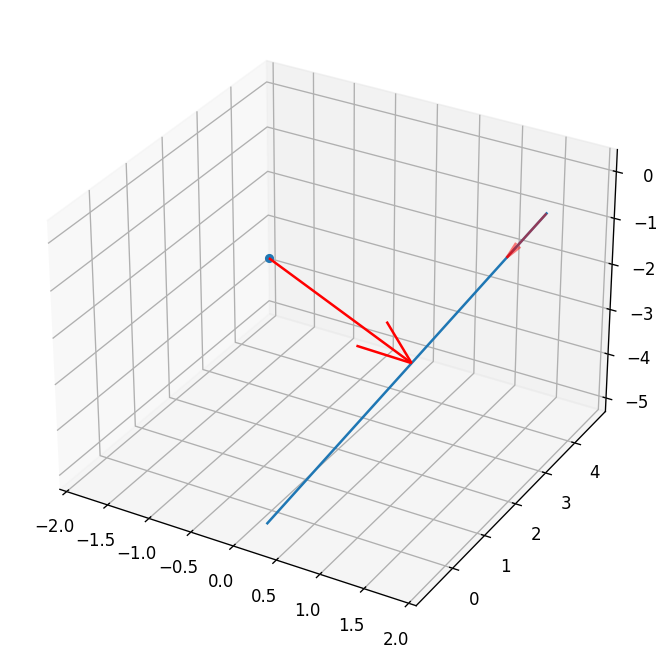

In [7]:
'''
Plot the image of a track vector, a sensor, and the b-vector (impact parameter) between the track and the sensor
'''
#Creates an array for sensor position and basis vector of the track
c = np.repeat(np.array([[0,0,.1]]),N,axis=0)
d = chime.find_basis_vectors(c.T,entry_vecs,exit_vecs)

#Checks shapes of the new arrays
assert np.linalg.norm(d[2], axis=0).shape == (N,)
assert np.repeat(np.array([[0,0,.1]]),N,axis=0).T.shape == (3, N)


fig = plt.figure(figsize=(8, 7), dpi=120)
ax = fig.add_subplot(111, projection='3d')

ax.plot(*np.concatenate(([entry_vecs[:,0]], [exit_vecs[:,0]]), axis=0).T)
ax.scatter(*c[0])
ax.quiver(*c[0], *(d[2][:,0]), color='red')
ax.quiver(*entry_vecs[:,0], *(d[1][:,0]), color='red', alpha=0.5)
ax.set(xlim=[-2,2])
plt.show()

In [8]:
'''
More asserts to check that the vector math is correct.
'''

assert np.dot(d[2][:,0],d[1][:,0]) < 1e-15

sensor_orientation = np.repeat(np.array([[0,0,1]]),N,axis=0).T
signal_test = chime.signal(
    np.array([1]),
    np.array([1]),
    np.array([[0,0,1]]).T,
    np.array([[0,0,1]]).T,
    np.array([[0,0,1]]).T,
    mass=1, min_impact_parameter=min_impact_parameter
)

assert np.abs(G**2*np.pi/2 - signal_test[0]) < 1e-15

### Applying noise

The $\sigma_{noise}$ from [this note](https://github.com/windchimeproject/documentation_and_notes/blob/main/analysis_notes/Analytic_SNR_for_a_single_sensor.pdf) is related to $\alpha$ from [Dan et. al.'s paper](https://arxiv.org/abs/1903.00492) in this way:

$$m_{sensor}^2\frac{\sigma_{noise}^2}{\Delta t} = \alpha$$

as such, we can try to recreate plots from Dan's papers without worrying about the noise bandwidth.

below in the code, I will use the noise parameter $\beta=\frac{\alpha}{m_{sensor}^2}$.

From the above linked note where I calculated the SNR expression, it can be seen that the SNR with template matching is simply $\sqrt{\frac{S}{\beta}}$.

(Credit to Juehang Qin, 2021)

In [9]:
'''
Some variable renaming and creation of 7xN array of track_parameters.
'''

velocity = vel
position_entry = entry_vecs
position_exit = exit_vecs

track_parameters = np.vstack((velocity, position_entry, position_exit))
track_parameters.shape

(7, 1000)

In [10]:

sensor_positions = sensor_coords
sensor_positions.shape
sensor_positions

array([[-5. , -5. , -5. , ...,  5. ,  5. ,  5. ],
       [-5. , -5. , -5. , ...,  5. ,  5. ,  5. ],
       [-5. , -4.9, -4.8, ...,  4.8,  4.9,  5. ]])

In [11]:
track_parameters.T.shape

(1000, 7)

In [12]:
'''
Number of bins/binsize to be used for the simulation
'''
NUMBER_OF_BINS = 2000 # many bins, can always reduce
# np.log10(min_impact_parameter), np.log10(length_x)
BINS_B = np.logspace(np.log10(min_impact_parameter), np.log10(length_x), NUMBER_OF_BINS)
BINS_SNR = np.linspace(0, 15, NUMBER_OF_BINS)

In [13]:
SNRhist, bhist, noisehist = chime.simulate(track_parameters, sensor_positions, beta=beta, bins_snr=BINS_SNR, bins_b=BINS_B)
print(SNRhist, bhist, noisehist)

1000it [03:16,  5.09it/s]

[       nan 0.00274067 0.00387589 ... 0.12247446 0.12250512 0.12253577] [4.64623507e-06 4.66410887e-06 4.68205142e-06 ... 9.93343630e-03
 9.97164965e-03 1.00100100e-02] [0.00000000e+00 7.51126314e-06 1.50225263e-05 ... 1.49999925e-02
 1.50075038e-02 1.50150150e-02]



/home/cdyall01/home/Windchime-SimAndAnalysis/windchime.py:162: RuntimeWarning: invalid value encountered in true_divide
  return snr_bin_data/np.sqrt(sqrt_noise_bin_data), b_bin_data, sqrt_noise_bin_data


### Sensitivity Curve Plotting

In [14]:
BINS_SNR = np.linspace(0, 15, NUMBER_OF_BINS+1)
BINS_B = np.logspace(np.log10(min_impact_parameter), np.log10(length_x), NUMBER_OF_BINS+1)
spacing= 0.1

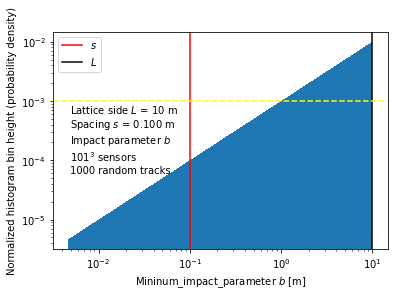

In [15]:
'''
PLots the minimum impact parameters for each track as a histogram normalized over the number of tracks
'''

fig, ax = plt.subplots()
ax.bar(BINS_B[:-1],
       bhist,
       width=np.diff(BINS_B),
       align="edge")

plt.loglog()
plt.axvline(spacing, label='$s$', color='red')
plt.axvline(length_x, label='$L$', color='black')
plt.legend()
plt.xlabel('Mininum_impact_parameter $b$ [m]')
plt.ylabel('Normalized histogram bin height (probability density)')
plt.axhline(1e-3, color='yellow', ls='--')
plt.text(0.05, 0.35, f'Lattice side $L$ = {length_x} m\nSpacing $s$ = {spacing:0.3f} m\nImpact parameter $b$\n{N_sensors_x}${{}}^3$ sensors\n{N} random tracks', transform=ax.transAxes)
_= plt.show()

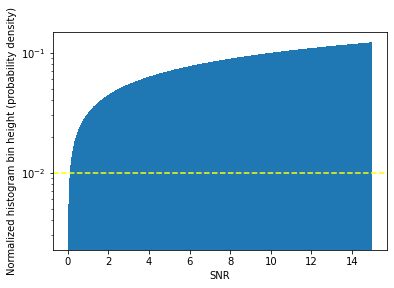

In [16]:
'''
Plots the SNRs of each track as a histogram normalized over the number of tracks
'''


fig, ax = plt.subplots()
ax.bar(BINS_SNR[:-1],
       SNRhist,
       width=np.diff(BINS_SNR),
       align="edge")

plt.semilogy()
plt.xlabel('SNR')
plt.ylabel('Normalized histogram bin height (probability density)')
plt.axhline(1e-2, color='yellow', ls='--')
_= plt.show()

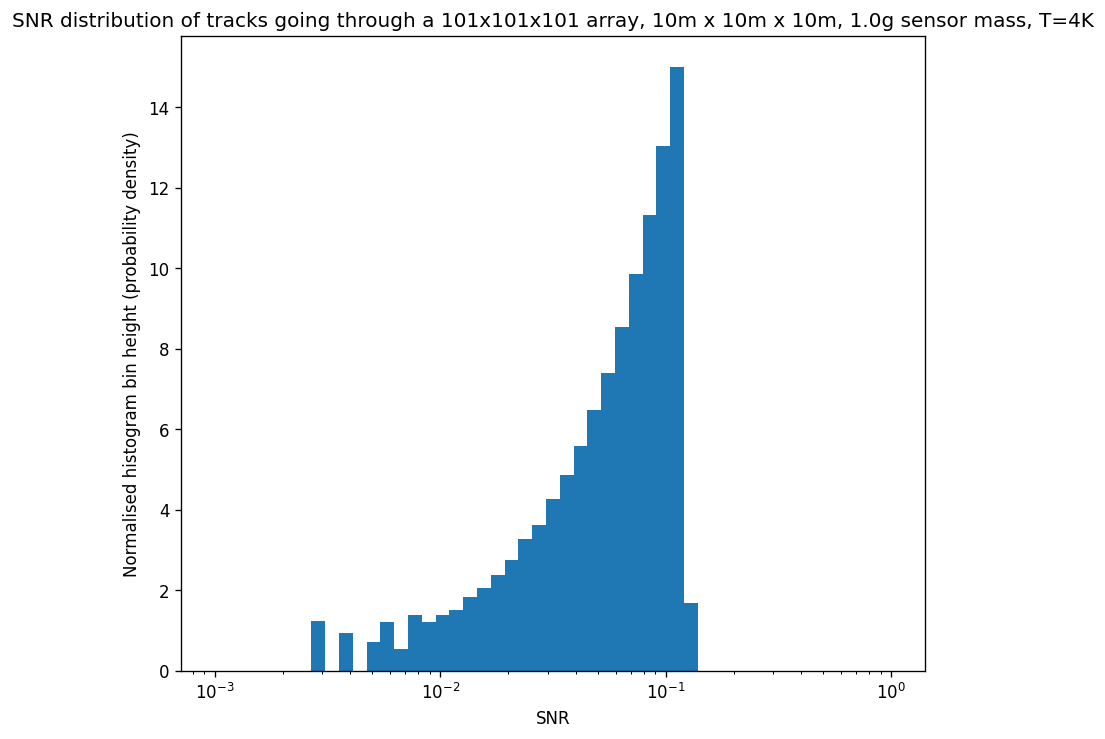

In [17]:
fig = plt.figure(figsize=(8, 7), dpi=120)
ax = fig.add_subplot(111)
ax.hist(SNRhist, density=True, bins=np.logspace(-3, 0))
plt.semilogx()
ax.set(xlabel='SNR', ylabel='Normalised histogram bin height (probability density)', title=f'SNR distribution of tracks going through a {N_sensors_x}x{N_sensors_y}x{N_sensors_z} array, {length_x}m x {length_y}m x {length_z}m, {sensor_mass*1000}g sensor mass, T=4K')
plt.show()

In [18]:
'''
Runs the simulate() function to return all SNRs and impact parameters for each sensor on each track
'''

individual_snrs, individual_b = chime.simulate(track_parameters, sensor_positions, beta, bins_snr=BINS_SNR, bins_b=BINS_B, return_all_snrs = True)

1000it [04:05,  4.08it/s]


In [19]:
np.max(individual_snrs)

6.414503891619668e-33

In [20]:
'''
Asserts here check for correct shape
'''
assert individual_snrs.shape == (N_sensors_x**3, N)
assert individual_b.shape == (N_sensors_x**3, N)

In [21]:
'''
Searches for when 3 sensors contain the majority of the signal
'''

best_3_contribution = []
best_N_contribution = []

for i in trange(N):
    sorted_indices = np.argsort(individual_snrs[:,i])
    best_3_contribution.append(np.sum(individual_snrs[:,i][sorted_indices[-3:]])/np.sum(individual_snrs[:,i]))
    best_N_contribution.append(np.sum(individual_snrs[:,i][sorted_indices[-N_sensors_x:]])/np.sum(individual_snrs[:,i]))

100%|██████████| 1000/1000 [02:21<00:00,  7.06it/s]


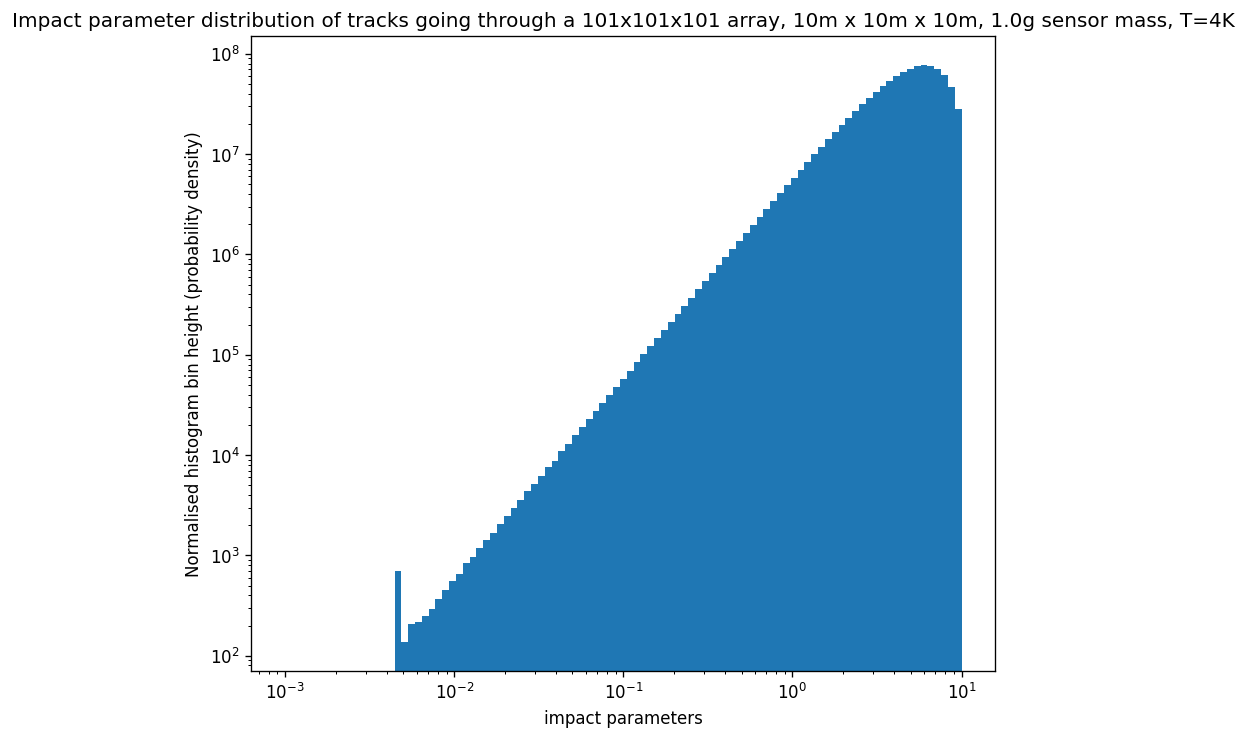

In [22]:
'''
Plot the distribution of all impact parameters of all tracks 
'''

fig = plt.figure(figsize=(8, 7), dpi=120)
ax = fig.add_subplot(111)
ax.hist(individual_b.reshape(-1,1), bins=np.logspace(-3,1,100))
ax.set(xlabel='impact parameters', ylabel='Normalised histogram bin height (probability density)', title=f'Impact parameter distribution of tracks going through a {N_sensors_x}x{N_sensors_y}x{N_sensors_z} array, {length_x}m x {length_y}m x {length_z}m, {sensor_mass*1000}g sensor mass, T=4K', xscale='log', yscale='log')
plt.show()

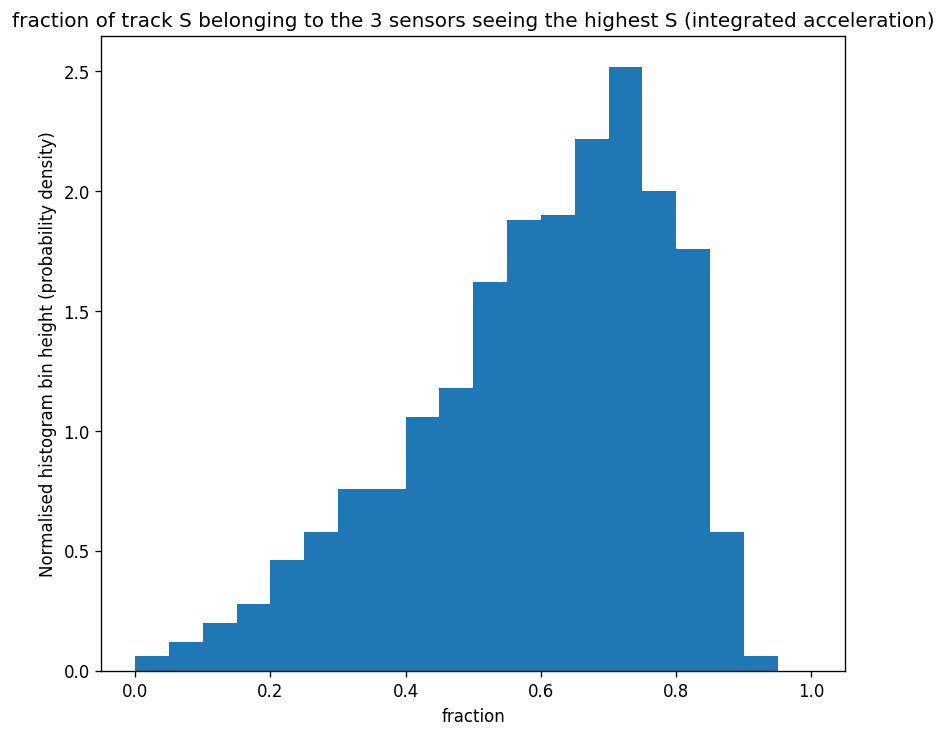

In [23]:
'''
Plot fraction of tracks where 3 sensors see the highest signal
'''

fig = plt.figure(figsize=(8, 7), dpi=120)
ax = fig.add_subplot(111)
ax.hist(best_3_contribution, density=True, bins=np.linspace(0,1,21))
ax.set(xlabel='fraction', ylabel='Normalised histogram bin height (probability density)', title='fraction of track S belonging to the 3 sensors seeing the highest S (integrated acceleration)')
plt.show()

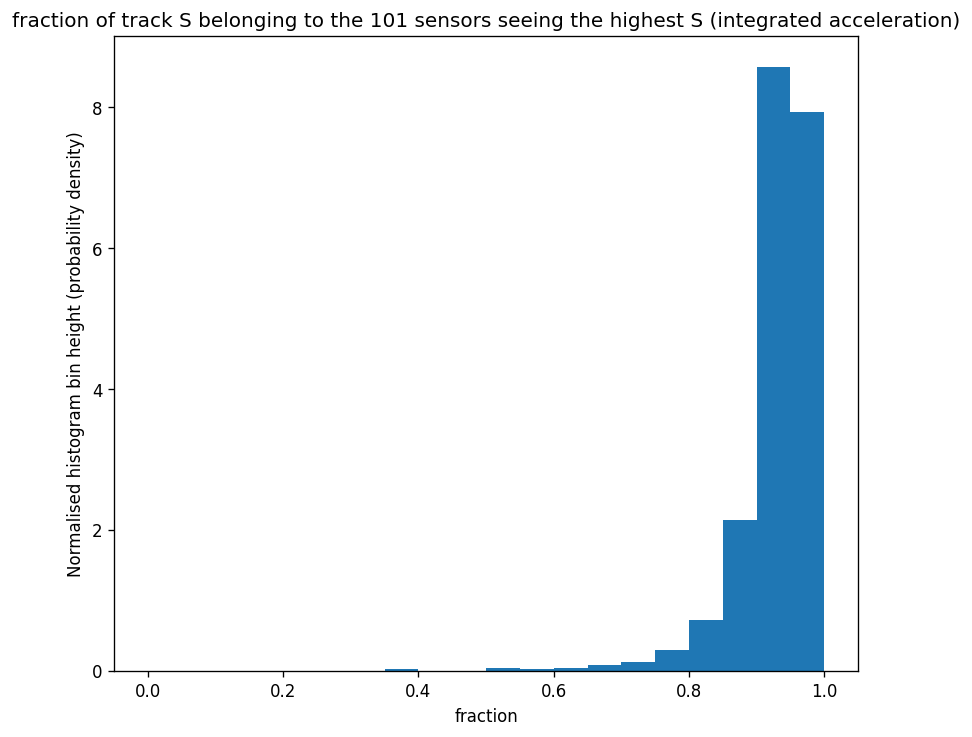

In [24]:
'''
Plot fraction of tracks where N_sensors_x see the highest signal
'''

fig = plt.figure(figsize=(8, 7), dpi=120)
ax = fig.add_subplot(111)
ax.hist(best_N_contribution, density=True, bins=np.linspace(0,1,21))
ax.set(xlabel='fraction', ylabel='Normalised histogram bin height (probability density)', title=f'fraction of track S belonging to the {N_sensors_x} sensors seeing the highest S (integrated acceleration)')
plt.show()

In [25]:
'''
Dark matter velocity and density constants as well as the expected # of events per year in detector
'''

v_dm = 220e3 #m/s
rho_dm = 0.3*GeV_per_c2*(100**3) #kg/m^3

In [26]:
'''
Gets the noise PSD for each track
'''

T_arr_edges = np.logspace(-3, 1, 51)
T_arr = T_arr_edges[:-1] + np.diff(T_arr_edges)/2
beta_arr = chime.beta_func(T=T_arr)

In [27]:
'''
Gives expected rate through radius
'''

expected_rate_through_radius = rho_dm*v_dm/mass_dm*3600*24*365*np.pi*radius**2 #events per year

In [28]:
'''
Calculates noise and which signals gave a >6 SNR treshold
'''

SNR_threshold = 6
pdf_parameters = np.zeros((len(beta_arr), 2))
for i,b in enumerate(tqdm(beta_arr)):
    SNRs = chime.SNRs_from_S_and_beta(individual_snrs, b)
    detected = np.sum(SNRs > SNR_threshold)
    pdf_parameters[i] = (detected+0.5, N+0.5-detected)

100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


In [29]:
'''
Uses many density multipliers to see how they would change the likelihood of detection
'''

multipliers_edges = np.linspace(0.5,5,151)
multipliers = np.linspace(0.5,5,151)

fraction_with_detections = np.zeros((len(beta_arr), len(multipliers)))
trials=10000

for i in trange(len(beta_arr)):
    for j,mult in enumerate(multipliers):
        detected_particles = chime.toy_MC_poisson_detection(expected_rate_through_radius*mult, pdf_parameters[i], trials=trials)
        fraction_with_detections[i,j] = np.sum(detected_particles > 0)/trials

100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


<ipython-input-30-d6986a2a009f>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  s = ax.pcolormesh(X, Y, fraction_with_detections, cmap=cmap)


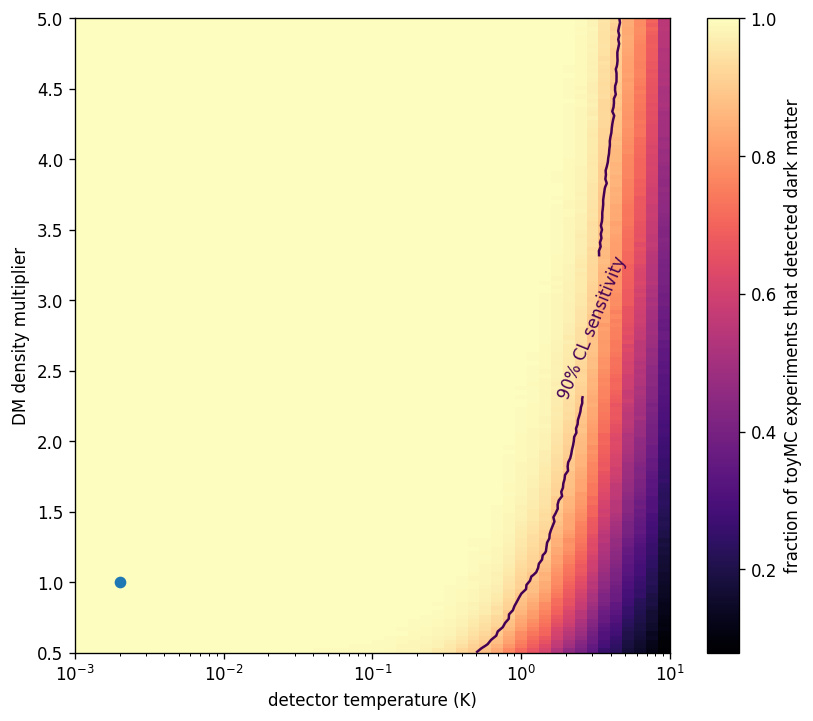

In [30]:
'''
Plots the fraction of toyMC experiemnts that detected dark matter as a 2D histogram of the temperature and DM density multiplier
'''

T_violin = 2e-3

X,Y = np.meshgrid(T_arr_edges, multipliers_edges, indexing='ij')
X_points,Y_points = np.meshgrid(T_arr, multipliers, indexing='ij')
cmap = cm.get_cmap('magma')
fig = plt.figure(figsize=(8, 7), dpi=120)
ax = fig.add_subplot(111)
s = ax.pcolormesh(X, Y, fraction_with_detections, cmap=cmap)
c = ax.contour(X_points, Y_points, fraction_with_detections, [0.9])
ax.clabel(c, c.levels, inline=True, fmt={c.levels[0]: '90% CL sensitivity'},)
ax.scatter([T_violin], [1], label='violin plot point')
cb = plt.colorbar(s)
cb.set_label('fraction of toyMC experiments that detected dark matter')
ax.set(xlabel='detector temperature (K)', ylabel='DM density multiplier', xscale='log')
plt.show()

--------------

In [31]:
b = chime.beta_func(T=T_violin)
SNRs = chime.SNRs_from_S_and_beta(individual_snrs, b)
detected_bool = SNRs >= SNR_threshold

detected_tracks_sensor_SNR = np.sqrt(individual_snrs[:, detected_bool]/b)
detected_tracks_sensor_SNR_sorted_indices = np.argsort(detected_tracks_sensor_SNR, axis=0)

In [32]:
best_N_sensors_to_plot = 5

detected_tracks = np.sum(detected_bool)
SNRs_for_best_N_sensors = np.zeros((best_N_sensors_to_plot, detected_tracks))

for i in trange(detected_tracks):
    indices_to_select = detected_tracks_sensor_SNR_sorted_indices[-1:-best_N_sensors_to_plot-1:-1,i]
    SNRs_for_best_N_sensors[:, i] = detected_tracks_sensor_SNR[indices_to_select, i]

100%|██████████| 997/997 [00:00<00:00, 337971.48it/s]


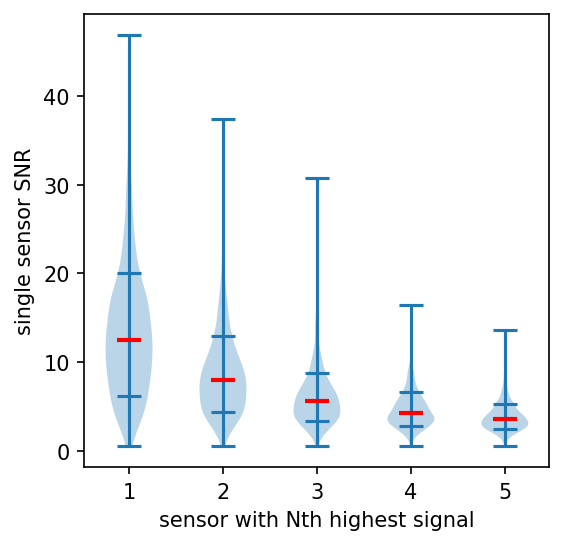

Plot of the SNRs of the 5 brightest sensors. The red horizontal line indicates the median, and the blue horizontal lines indicate the 1-sigma bounds and the extremal values. The shaded regions represent the probability density functions of the SNR distributions.


In [34]:

fig = plt.figure(figsize=(4, 4), dpi=150)
ax = fig.add_subplot(111)

# violin_dict = ax.violinplot(
#     SNRs_for_best_N_sensors.T, 
#     quantiles=np.repeat(stats.norm.cdf([[-1,1]]), best_N_sensors_to_plot, axis=0).T,
#     showmedians=True)

violin_dict = ax.violinplot(
    SNRs_for_best_N_sensors.T, positions=None, vert=True, widths=0.5, showmeans=False, showextrema=True, showmedians=True,
    quantiles=np.repeat(stats.norm.cdf([[-1,1]]), best_N_sensors_to_plot, axis=0).T)

violin_dict['cmedians'].set_linewidth(2)
violin_dict['cmedians'].set_color('r')

ax.set(xlabel='sensor with Nth highest signal', ylabel='single sensor SNR', )
plt.show()


print('Plot of the SNRs of the 5 brightest sensors. The red horizontal line indicates the median, and the blue horizontal lines indicate the 1-sigma bounds and the extremal values. The shaded regions represent the probability density functions of the SNR distributions.')

----------------

In [35]:
dm_masses_gev_edges = np.logspace(18.5,21,31)
dm_masses_gev = dm_masses_gev_edges[:-1] + np.diff(dm_masses_gev_edges)/2
dm_masses_SI = dm_masses_gev*GeV_per_c2
dm_rates = chime.dm_events_per_year(mass_dm=dm_masses_SI)

In [38]:
T_arr_edges = np.logspace(-3, 0, 31)
T_arr = T_arr_edges[:-1] + np.diff(T_arr_edges)/2
beta_arr = chime.beta_func(T=T_arr)

SNR_threshold = 6
pdf_parameters = np.zeros((len(beta_arr), 2))

fraction_with_detections = np.zeros((len(beta_arr), len(dm_masses_SI)))

for i,b in enumerate(tqdm(beta_arr)):
    for j,dm_mass_thisloop in enumerate(dm_masses_SI):
        signal_mult = (dm_mass_thisloop/mass_dm)**2
        SNRs = chime.SNRs_from_S_and_beta(individual_snrs*signal_mult, b)
        detected = np.sum(SNRs >= SNR_threshold)
        pdf_parameters = (detected+0.5, N+0.5-detected)
        
        detected_particles = chime.toy_MC_poisson_detection(dm_rates[j], pdf_parameters, trials=trials)
        fraction_with_detections[i,j] = np.sum(detected_particles > 0)/trials

100%|██████████| 30/30 [1:13:32<00:00, 147.08s/it]


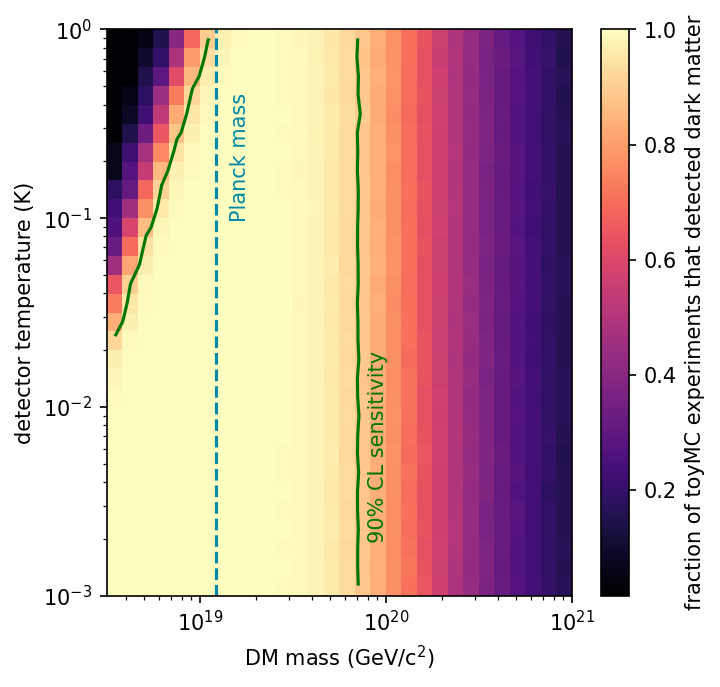

NameError: name 'print_caption' is not defined

In [39]:
X,Y = np.meshgrid(dm_masses_gev_edges, T_arr_edges, indexing='ij')
X_points,Y_points = np.meshgrid(dm_masses_gev, T_arr, indexing='ij')
cmap = cm.get_cmap('magma')
fig = plt.figure(figsize=(5, 5), dpi=150)
ax = fig.add_subplot(111)
s = ax.pcolormesh(X, Y, fraction_with_detections.T, cmap=cmap)
c = ax.contour(X_points, Y_points, fraction_with_detections.T, [0.9], colors='#007700')
ax.text(0.8e20, 2e-3, '90% CL sensitivity', rotation=90, color='#007700')

cb = plt.colorbar(s)
cb.set_label('fraction of toyMC experiments that detected dark matter')

ax.vlines([1.22e19], ymin=T_arr_edges[0], ymax=T_arr_edges[-1], color='#0088AA', linestyle='--')
ax.text(1.45e19, 1e-1, 'Planck mass', rotation=90, color='#0088AA')

ax.set(xlabel=r'DM mass (GeV/c$^2$)', ylabel='detector temperature (K)', xscale='log', yscale='log')
plt.show()

print_caption(r'Sensitivity of the windchime experiment with a $101^3$ sensor array with 1 g test masses and 10 metre sides, as a function of temperature to various dark matter masses. This corresponds to an exposure of 1 year.')

In [ ]:
dm_events_per_year(mass_dm=7e19*GeV_per_c2, rho_dm=rho_dm, v_dm=v_dm)